## Visualização dos dados

<Figure size 1200x1000 with 0 Axes>

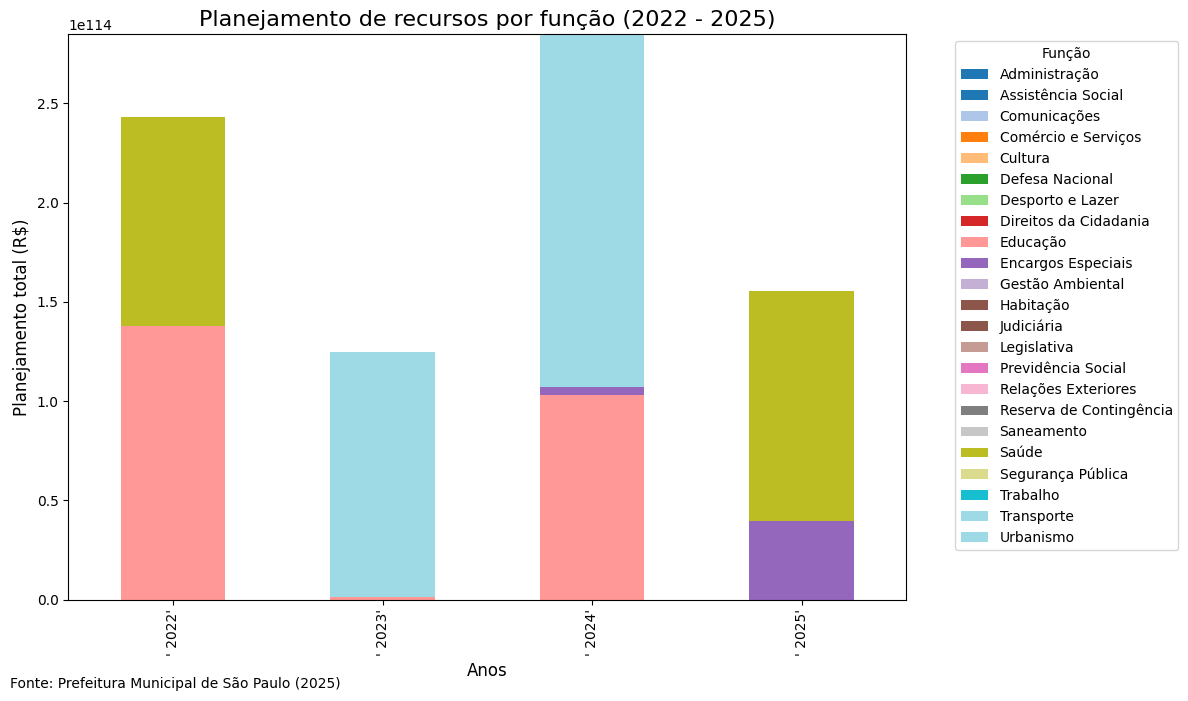

In [2]:
import matplotlib.pyplot as plt
from utils.load_csv import load_csv

df_ppa_fonte = load_csv("ppa_fonte.csv")

cols_grafico = ["descricao da funcao", 
                "\' 2022\'", 
                "\' 2023\'", 
                "\' 2024\'", 
                "\' 2025\'"]

df_ppa_fonte = df_ppa_fonte[cols_grafico]

df_agrupado = df_ppa_fonte.groupby("descricao da funcao").sum()

df_agrupado = df_agrupado.T

plt.figure(figsize=(12, 10))

df_agrupado.plot(kind='bar', 
                 stacked=True, 
                 figsize=(12, 7), 
                 colormap='tab20')

plt.title("Planejamento de recursos por função (2022 - 2025)", fontsize=16)
plt.ylabel("Planejamento total (R$)", fontsize=12)
plt.xlabel("Anos", fontsize=12)

plt.legend(title="Função", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.figtext(0.01, 0.01,
            "Fonte: Prefeitura Municipal de São Paulo (2025)",
            ha = "left", fontsize = 10)

plt.tight_layout()
plt.show()